風速區間 4.0–4.5 m/s，資料筆數： 1712


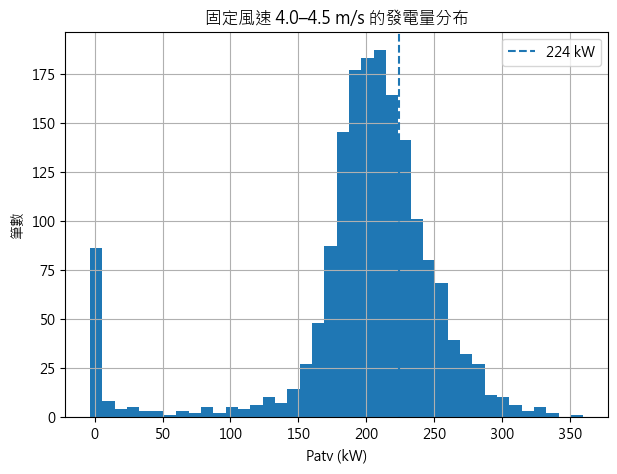

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["font.family"] = "Microsoft JhengHei"  # 微軟正黑體
mpl.rcParams["axes.unicode_minus"] = False          # 解決負號顯示問題


# 讀資料
df = pd.read_csv("TurbID3.csv")
df = df[df["TurbID"] == 3].copy()

# 建立風速 bin（每 0.5 m/s）
df["Wspd_bin"] = (df["Wspd"] // 0.5) * 0.5

# 只看你關心的低中風速區（可自行調整）
target_bin = 4.0
df_bin = df[df["Wspd_bin"] == target_bin]

print(f"風速區間 {target_bin}–{target_bin+0.5} m/s，資料筆數：", len(df_bin))

# 畫 Patv 分布
plt.figure(figsize=(7,5))
plt.hist(df_bin["Patv"], bins=40)
plt.axvline(224, linestyle="--", label="224 kW")
plt.xlabel("Patv (kW)")
plt.ylabel("筆數")
plt.title(f"固定風速 {target_bin}–{target_bin+0.5} m/s 的發電量分布")
plt.legend()
plt.grid(True)
plt.show()


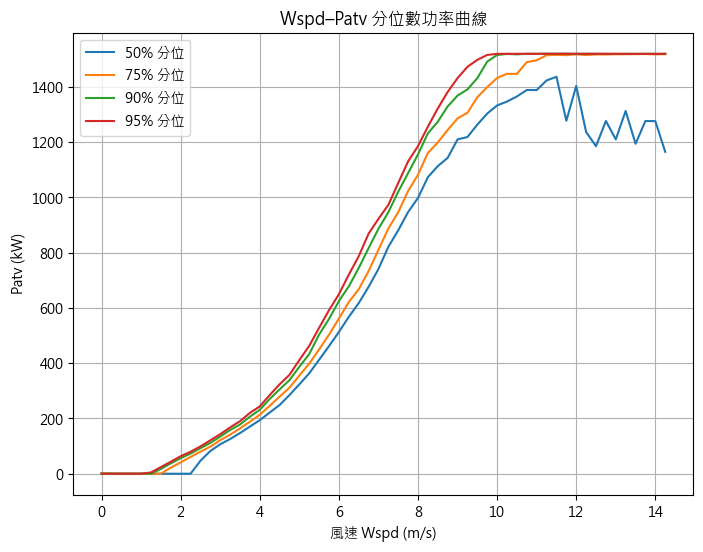

In [6]:
# 建立更細的風速 bin
df["Wspd_bin_fine"] = (df["Wspd"] // 0.25) * 0.25

quantiles = [0.5, 0.75, 0.9, 0.95]
records = []

for wspd_bin, g in df.groupby("Wspd_bin_fine"):
    if len(g) < 50:  # 筆數太少跳過
        continue
    for q in quantiles:
        records.append({
            "Wspd_bin": wspd_bin,
            "quantile": q,
            "Patv": g["Patv"].quantile(q)
        })

qdf = pd.DataFrame(records)

# 繪圖
plt.figure(figsize=(8,6))
for q in quantiles:
    tmp = qdf[qdf["quantile"] == q]
    plt.plot(tmp["Wspd_bin"], tmp["Patv"], label=f"{int(q*100)}% 分位")

plt.xlabel("風速 Wspd (m/s)")
plt.ylabel("Patv (kW)")
plt.title("Wspd–Patv 分位數功率曲線")
plt.legend()
plt.grid(True)
plt.show()


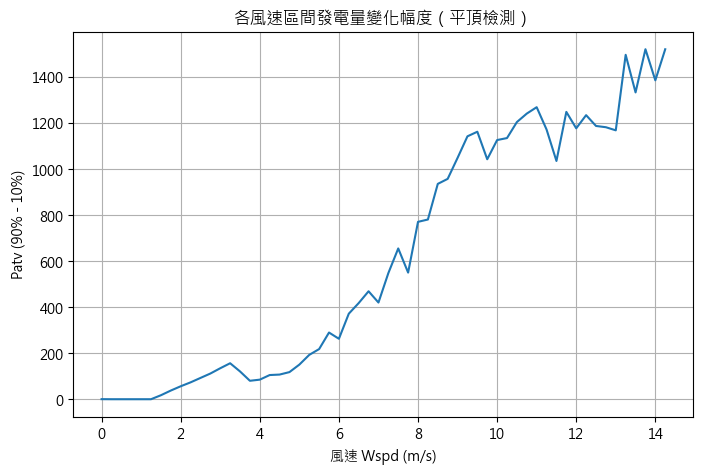

In [7]:
# 對風速 bin 計算 Patv 的變化
plateau_records = []

for wspd_bin, g in df.groupby("Wspd_bin_fine"):
    if len(g) < 50:
        continue

    p90 = g["Patv"].quantile(0.9)
    p10 = g["Patv"].quantile(0.1)

    plateau_records.append({
        "Wspd_bin": wspd_bin,
        "Patv_range": p90 - p10,
        "Patv_mean": g["Patv"].mean()
    })

plateau_df = pd.DataFrame(plateau_records)

# 畫變化幅度
plt.figure(figsize=(8,5))
plt.plot(plateau_df["Wspd_bin"], plateau_df["Patv_range"])
plt.xlabel("風速 Wspd (m/s)")
plt.ylabel("Patv (90% - 10%)")
plt.title("各風速區間發電量變化幅度（平頂檢測）")
plt.grid(True)
plt.show()


Total samples: 35280
Samples after dropping NaN: 34928
Identified regimes: 2
Noise samples: 3552


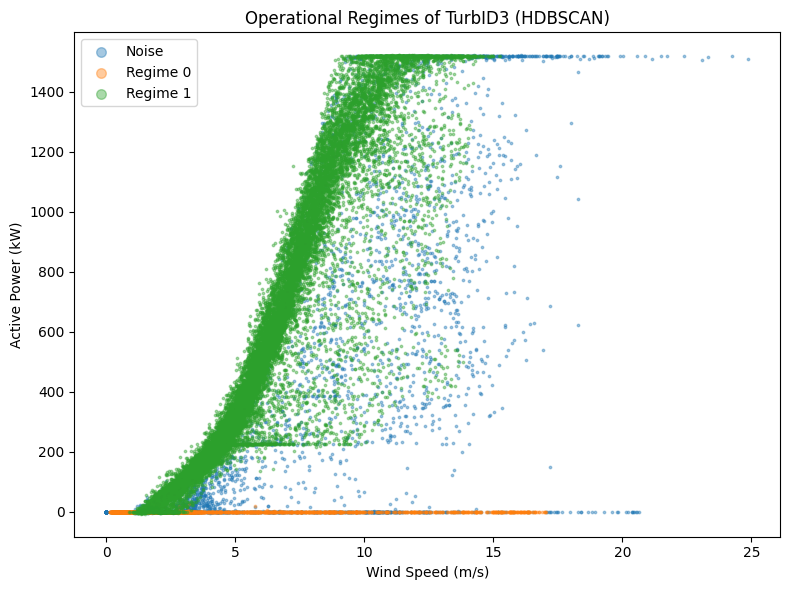


=== Regime Summary Statistics ===
            Wspd                         Patv                      Pab_mean  \
            mean       std  count        mean         std  count       mean   
regime                                                                        
0.0     2.224984  2.519774   8271   -0.287439    0.417341   8271  90.051911   
1.0     6.084299  2.811068  23105  559.604165  457.264941  23105   1.831398   

                          Pab_std                      Yaw_err              \
             std  count      mean       std  count        mean         std   
regime                                                                       
0.0     2.143772   8271  0.030474  0.046464   8271  208.376936  137.795183   
1.0     5.090177  23105  0.001406  0.004050  23105  221.676940  124.582658   

               
        count  
regime         
0.0      8271  
1.0     23105  


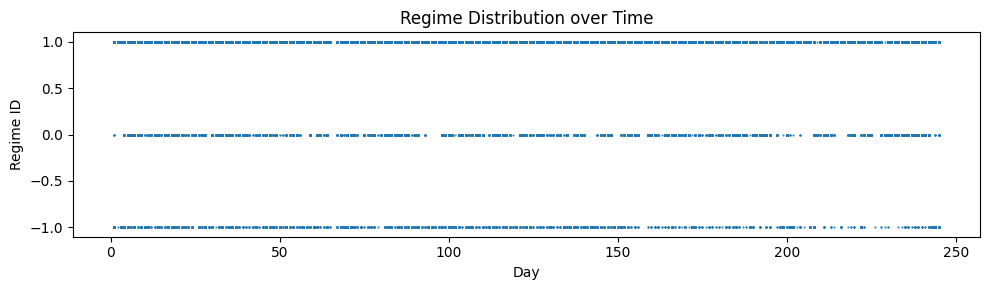

In [1]:
# ============================================
# Unsupervised Operational Regime Identification
# TurbID3 - HDBSCAN
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import hdbscan

# --------------------------------------------
# 1. Load data
# --------------------------------------------
df = pd.read_csv("TurbID3.csv")

print("Total samples:", len(df))

# --------------------------------------------
# 2. Feature engineering (control-oriented)
# --------------------------------------------

# Pitch control features
df["Pab_mean"] = df[["Pab1", "Pab2", "Pab3"]].mean(axis=1)
df["Pab_std"]  = df[["Pab1", "Pab2", "Pab3"]].std(axis=1)

# Yaw misalignment (absolute error)
df["Yaw_err"] = np.abs(df["Ndir"] - df["Wdir"])

# Selected features for regime identification
features = [
    "Wspd",       # environmental input
    "Patv",       # system output
    "Pab_mean",   # control level
    "Pab_std",    # control stability
    "Yaw_err"     # yaw quality
]

df_feat = df[features].dropna()

print("Samples after dropping NaN:", len(df_feat))

# --------------------------------------------
# 3. Feature scaling
# --------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_feat)

# --------------------------------------------
# 4. HDBSCAN clustering
# --------------------------------------------
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=300,   # adjust based on data size
    min_samples=50,
    metric="euclidean"
)

labels = clusterer.fit_predict(X_scaled)

df.loc[df_feat.index, "regime"] = labels

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = np.sum(labels == -1)

print("Identified regimes:", n_clusters)
print("Noise samples:", n_noise)

# --------------------------------------------
# 5. Visualization: Power vs Wind Speed
# --------------------------------------------
plt.figure(figsize=(8, 6))

for r in sorted(df["regime"].dropna().unique()):
    subset = df[df["regime"] == r]

    plt.scatter(
        subset["Wspd"],
        subset["Patv"],
        s=3,
        alpha=0.4,
        label="Noise" if r == -1 else f"Regime {int(r)}"
    )

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Active Power (kW)")
plt.title("Operational Regimes of TurbID3 (HDBSCAN)")
plt.legend(markerscale=4)
plt.tight_layout()
plt.show()

# --------------------------------------------
# 6. Regime statistical summary
# --------------------------------------------
summary = (
    df[df["regime"] >= 0]
    .groupby("regime")[features]
    .agg(["mean", "std", "count"])
)

print("\n=== Regime Summary Statistics ===")
print(summary)

# --------------------------------------------
# 7. Optional: Time continuity check
# --------------------------------------------
# Useful to verify regime persistence
if "Day" in df.columns:
    plt.figure(figsize=(10, 3))
    plt.plot(df["Day"], df["regime"], ".", markersize=1)
    plt.xlabel("Day")
    plt.ylabel("Regime ID")
    plt.title("Regime Distribution over Time")
    plt.tight_layout()
    plt.show()

# --------------------------------------------
# End of script
# --------------------------------------------


Samples in Regime 1: 23105
Identified sub-regimes: 7
Noise samples (level 2): 5771


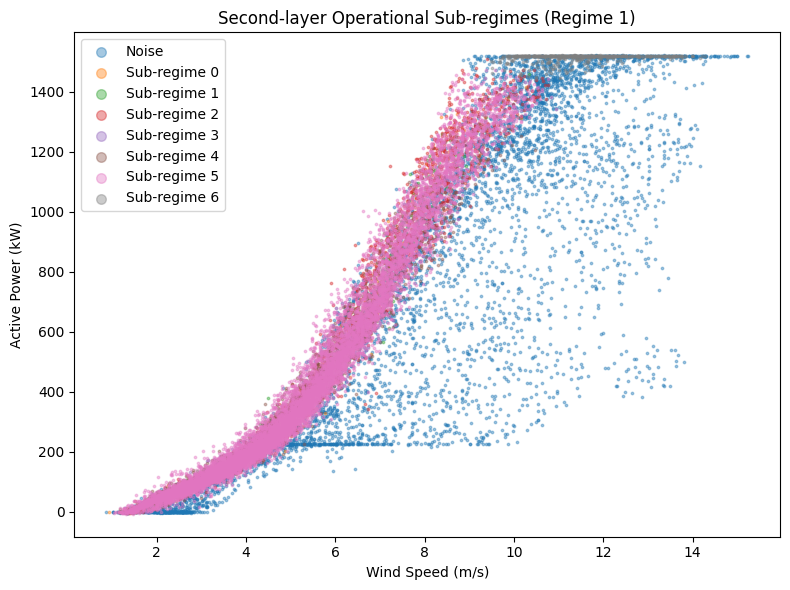

In [2]:
# --------------------------------------------
# 8. Second-layer clustering on Regime 1
# --------------------------------------------

df_r1 = df[df["regime"] == 1].copy()
print("Samples in Regime 1:", len(df_r1))
features_lvl2 = [
    "Patv",
    "Pab_mean",
    "Pab_std",
    "Yaw_err"
]

df_r1_feat = df_r1[features_lvl2].dropna()
scaler_lvl2 = StandardScaler()
X_lvl2 = scaler_lvl2.fit_transform(df_r1_feat)
clusterer_lvl2 = hdbscan.HDBSCAN(
    min_cluster_size=200,   # Regime 1 資料多，可以小一點
    min_samples=30,
    metric="euclidean"
)

labels_lvl2 = clusterer_lvl2.fit_predict(X_lvl2)

df.loc[df_r1_feat.index, "sub_regime"] = labels_lvl2

n_sub = len(set(labels_lvl2)) - (1 if -1 in labels_lvl2 else 0)
n_noise_lvl2 = (labels_lvl2 == -1).sum()

print("Identified sub-regimes:", n_sub)
print("Noise samples (level 2):", n_noise_lvl2)

plt.figure(figsize=(8, 6))

for r in sorted(df["sub_regime"].dropna().unique()):
    subset = df[df["sub_regime"] == r]

    plt.scatter(
        subset["Wspd"],
        subset["Patv"],
        s=3,
        alpha=0.4,
        label="Noise" if r == -1 else f"Sub-regime {int(r)}"
    )

plt.xlabel("Wind Speed (m/s)")
plt.ylabel("Active Power (kW)")
plt.title("Second-layer Operational Sub-regimes (Regime 1)")
plt.legend(markerscale=4)
plt.tight_layout()
plt.show()


Samples for classification: 17334
Number of sub-regimes: 7


C:\Users\jack6\AppData\Local\Temp\ipykernel_11344\2164774358.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = df_clf[explain_features].fillna(method="ffill")


              precision    recall  f1-score   support

           0       1.00      0.62      0.76        55
           1       0.88      0.91      0.90        89
           2       0.96      1.00      0.98       402
           3       0.91      0.95      0.93        76
           4       1.00      1.00      1.00       511
           5       1.00      1.00      1.00      2225
           6       0.99      0.97      0.98       109

    accuracy                           0.99      3467
   macro avg       0.96      0.92      0.94      3467
weighted avg       0.99      0.99      0.99      3467


=== Feature Importance ===
    feature  importance
4   Yaw_err    0.433233
3   Pab_std    0.334981
2  Pab_mean    0.114790
1      Patv    0.051011
0      Wspd    0.032278
7      Prtv    0.012709
6      Etmp    0.010527
5      Itmp    0.010471


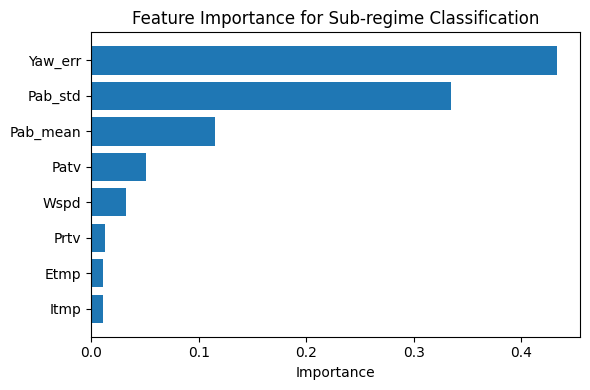

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 只取第二層有標籤的資料（排除 noise）
df_clf = df[df["sub_regime"] >= 0].copy()

print("Samples for classification:", len(df_clf))
print("Number of sub-regimes:", df_clf["sub_regime"].nunique())

explain_features = [
    "Wspd",
    "Patv",
    "Pab_mean",
    "Pab_std",
    "Yaw_err",
    "Itmp",
    "Etmp",
    "Prtv"
]

X = df_clf[explain_features].fillna(method="ffill")
y = df_clf["sub_regime"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=50,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))

importances = rf.feature_importances_
feat_imp = pd.DataFrame({
    "feature": explain_features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

print("\n=== Feature Importance ===")
print(feat_imp)

plt.figure(figsize=(6, 4))
plt.barh(
    feat_imp["feature"],
    feat_imp["importance"]
)
plt.xlabel("Importance")
plt.title("Feature Importance for Sub-regime Classification")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


SHAP samples: (2000, 8)
Number of sub-regimes (SHAP): 2000


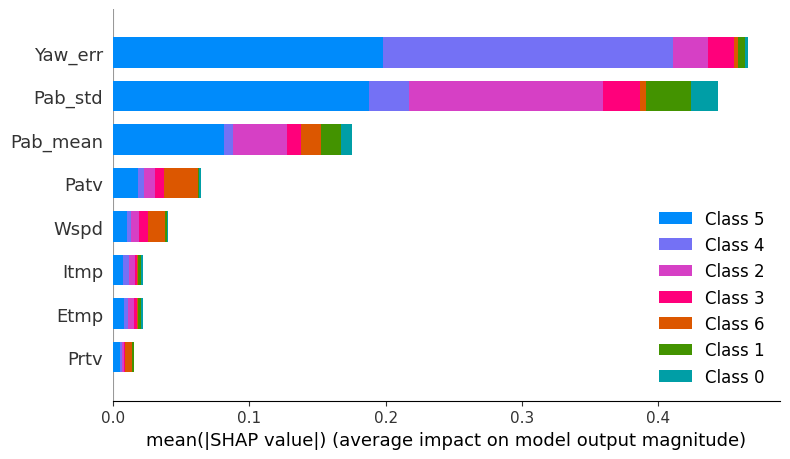

RF classes: [0 1 2 3 4 5 6]
Class index used for SHAP: 3
shap_values shape: (2000, 8, 7)
Selected SHAP shape: (2000, 7)
X_shap shape: (2000, 8)


AssertionError: SHAP shape mismatch!

In [ ]:
# ============================================================
# SHAP analysis for sub-regime interpretability (FIXED)
# ============================================================

import shap
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. 初始化 SHAP
# ------------------------------------------------------------
shap.initjs()

# ------------------------------------------------------------
# 2. 準備 SHAP 使用資料
# ------------------------------------------------------------
X_shap = X_train.sample(n=2000, random_state=42)
y_shap = y_train.loc[X_shap.index]

print("SHAP samples:", X_shap.shape)

# ------------------------------------------------------------
# 3. 建立 TreeExplainer
# ------------------------------------------------------------
explainer = shap.TreeExplainer(rf)

# ⚠️ 新版 SHAP：回傳 ndarray
# shape = (n_samples, n_features, n_classes)
shap_values = explainer.shap_values(X_shap)

print("shap_values shape:", shap_values.shape)

# ------------------------------------------------------------
# 4. （可選）整體重要性（bar）— 修正版
# ------------------------------------------------------------
# 使用「所有 class SHAP 絕對值平均」
shap_bar = np.mean(np.abs(shap_values), axis=2)

shap.summary_plot(
    shap_bar,
    X_shap,
    plot_type="bar",
    show=True
)

# ------------------------------------------------------------
# 5. ⭐ 核心圖：單一 sub-regime 的 SHAP beeswarm（正確版）
# ------------------------------------------------------------

target_regime = 3
print("RF classes:", rf.classes_)

# 找到 class index
class_index = list(rf.classes_).index(target_regime)
print("Class index used for SHAP:", class_index)

# ✅ 正確取法：(n_samples, n_features)
sv = shap_values[:, :, class_index]

print("Selected SHAP shape:", sv.shape)
print("X_shap shape:", X_shap.shape)

# 安全檢查
assert sv.shape == X_shap.shape, "SHAP shape mismatch!"

# 畫 beeswarm（你論文最重要的一張圖）
shap.summary_plot(
    sv,
    X_shap,
    feature_names=X_shap.columns,
    show=True
)

# ------------------------------------------------------------
# 6. （可選）單一變數 dependence plot（加分用）
# ------------------------------------------------------------
feature_to_plot = "Yaw_err"   # 或 "Pab_std", "Pab_mean"

shap.dependence_plot(
    feature_to_plot,
    sv,
    X_shap,
    show=True
)
